# CLV Modeling for Predictive Customer Analytics

This notebook implements a modular pipeline for estimating Customer Lifetime Value (CLV)
using transactional customer data. The objective is to translate historical purchase behavior
into actionable insights for customer segmentation and retention strategy design.


In [7]:
import sys
sys.executable


'c:\\ProgramData\\anaconda3\\python.exe'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

import warnings
warnings.filterwarnings("ignore")


In [11]:
from pathlib import Path

BASE_DIR = Path("..")   # because notebook is inside /notebooks
DATA_PATH = BASE_DIR / "data" / "raw" / "online_retail.csv"
OUTPUT_PATH = BASE_DIR / "data" / "processed" / "clv_results.csv"

CLV_HORIZON_MONTHS = 12
DISCOUNT_RATE = 0.01


In [ ]:
DATA_PATH = "data/raw/OnlineRetail.csv"
OUTPUT_PATH = "data/processed/clv_results.csv"

CLV_HORIZON_MONTHS = 12
DISCOUNT_RATE = 0.01


In [17]:

df = pd.read_csv(DATA_PATH, encoding="latin1")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [20]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


In [21]:
rfm = summary_data_from_transaction_data(
    df,
    customer_id_col="CustomerID",
    datetime_col="InvoiceDate",
    monetary_value_col="TotalPrice",
    observation_period_end=df["InvoiceDate"].max()
)

rfm.head()
# Create total transaction value
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


In [22]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm["frequency"], rfm["recency"], rfm["T"])


<lifetimes.BetaGeoFitter: fitted with 4010 subjects, a: 0.02, alpha: 54.01, b: 0.27, r: 0.78>

In [24]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

# Filter customers with monetary value
rfm = rfm[rfm["monetary_value"] > 0]

# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm["frequency"], rfm["recency"], rfm["T"])

# Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm["frequency"], rfm["monetary_value"])


<lifetimes.GammaGammaFitter: fitted with 2433 subjects, p: 3.17, q: 0.33, v: 3.62>

In [25]:
rfm["clv"] = ggf.customer_lifetime_value(
    bgf,
    rfm["frequency"],
    rfm["recency"],
    rfm["T"],
    rfm["monetary_value"],
    time=CLV_HORIZON_MONTHS,
    discount_rate=DISCOUNT_RATE
)

rfm.sort_values("clv", ascending=False).head()


,frequency,recency,T,monetary_value,clv
CustomerID,,,,,
14646.0,38.0,311.0,315.0,6235.862895,210758.933118
18102.0,22.0,318.0,328.0,10214.015909,199952.352478
17450.0,26.0,328.0,328.0,6087.781538,139293.431990
12415.0,13.0,272.0,298.0,9035.176923,118537.392302
14156.0,41.0,326.0,333.0,2542.223659,88356.997751


In [26]:
rfm.to_csv("../data/processed/rfm_features.csv", index=False)
rfm.to_csv("../data/processed/clv_results.csv", index=False)


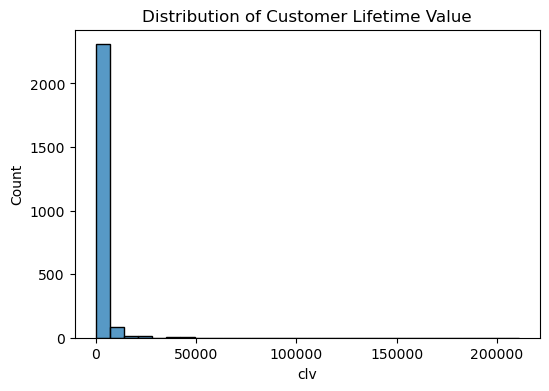

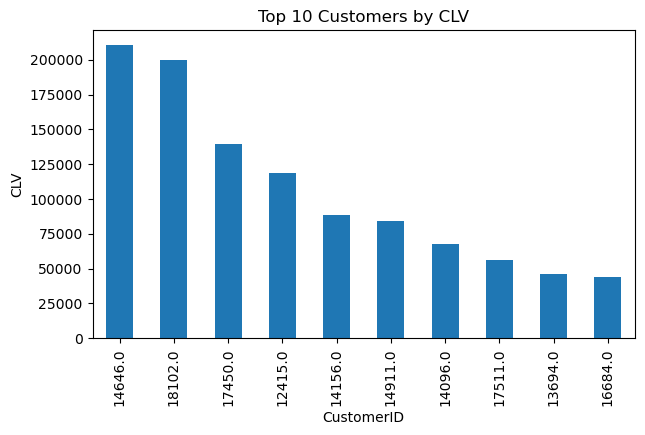

In [27]:
plt.figure(figsize=(6,4))
sns.histplot(rfm["clv"], bins=30)
plt.title("Distribution of Customer Lifetime Value")
plt.show()

top_customers = rfm.sort_values("clv", ascending=False).head(10)
top_customers["clv"].plot(kind="bar", figsize=(7,4))
plt.title("Top 10 Customers by CLV")
plt.ylabel("CLV")
plt.show()


## Business Interpretation

Customers with higher predicted CLV represent long-term revenue potential
and should be prioritized for retention initiatives and loyalty programs.
Lower-value customers can be targeted using cost-efficient engagement
strategies.

These CLV estimates are later combined with churn prediction outputs to
identify high-value customers at risk of leaving.
